In [1]:
import numpy as np 
import cv2 
import glob 
import matplotlib.pyplot as plt 
import pickle 
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
images = glob.glob('test_images/*.jpg')

In [11]:
def threshold(img, sx_thresh = (20,100), s_thresh = (150,255)): 
    # thresholding using S channel from HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sat = hls[:,:,2]

    # thresholding using R channel from RGB color space 
    red = img[:,:,0]

    # sobel x 
    sobelx = cv2.Sobel(red, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # threshold x gradient 
   
    sx_binary = np.zeros_like(scaled)
    sx_binary[(scaled > sx_thresh[0]) & (scaled <= sx_thresh[1])] = 1

    # thresh S channel
    
    s_binary = np.zeros_like(sat)
    s_binary[(sat > s_thresh[0]) & (sat <= s_thresh[1])] = 1

    # combine binary thresholds 
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(sx_binary == 1) | (s_binary == 1)] = 1
    
    return combined_binary

In [43]:
def transform_matrix(img_size, offset=75):
    '''
    Calculate perspective transform matrix AND its inverse 
    '''
    # source points: trapezoid surrounding the lane lines
    src = np.float32([[-25, img_size[1]], 
                      [570, 450],
                      [720, 450],
                      [1400, img_size[1]]])
    
    # destination points: entire image w/ offset 
    # TODO: find better destination points
    dst = np.float32([[offset, img_size[1]], 
                      [offset, 0], 
                      [img_size[0]-offset, 0],
                      [img_size[0]-offset, img_size[1]]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    return M, M_inv

In [13]:
def hist(img):
    bottom_half = img[img.shape[0]//2:, :]
    
    # sum image pixels vertically
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

In [32]:
def find_lane_pixels(histogram, img):
    #create output img to draw on + visualize result
    out_img = np.dstack((img,img,img))
    
    # find 2 peaks on the halves of histogram
    midpt = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpt])
    rightx_base = np.argmax(histogram[midpt:]) + midpt
    
    # window HYPERPARAMS
    nwindows = 9
    margin = 100 # width of windows, +/- margin 
    minpix = 50 # min pixels found to recenter window
    
    # window height 
    win_height = np.int(out_img.shape[0]//nwindows)
    
    # x + y positions of nonzero pixels in image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # current pos to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # create empty lists for left + right lane pixel indices 
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # id window boundaries in x and y 
        win_y_low = img.shape[0] - (window+1)*win_height
        win_y_high = img.shape[0] - window*win_height
        
        # TODO: Find x boundaries for windows
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # draw windows 
        cv2.rectangle(out_img, 
                      (win_xleft_low, win_y_low), 
                      (win_xleft_high, win_y_high), (0,255,0), 3)
        
        cv2.rectangle(out_img, 
                      (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high), (0,255,0), 3)
        
        good_left_inds = [i for i in range(len(nonzerox)) \
                          if nonzeroy[i] >= win_y_low and nonzeroy[i] <= win_y_high \
                          and nonzerox[i] >= win_xleft_low and nonzerox[i] <= win_xleft_high ]
        good_right_inds = [i for i in range(len(nonzerox)) \
                          if nonzeroy[i] >= win_y_low and nonzeroy[i] <= win_y_high \
                          and nonzerox[i] >= win_xright_low and nonzerox[i] <= win_xright_high ]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # TODO: found > minpix pixels, recenter next window 
        if len(good_left_inds) > minpix:
            leftx_current = np.mean([nonzerox[i] for i in good_left_inds]).astype(int)
        if len(good_right_inds) > minpix:
            rightx_current = np.mean([nonzerox[i] for i in good_right_inds]).astype(int)
            
    # concat arrays of good indices 
    try:
        left_lane_inds = np.concatenate(left_lane_inds).astype(int)
        right_lane_inds = np.concatenate(right_lane_inds).astype(int)
    except ValueError:
        pass
    
    # extract left and right line pixel positions 
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img


def fit_poly(img_shape, leftx, lefty, rightx, righty):    
    # TODO: fit 2nd order poly using np.polyfit
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x + y values for plotting 
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        left_fitx = 1*ploty**2 + ploty
        right_fitx = 1*ploty**2 + ploty
 
    return left_fitx, right_fitx, ploty

    

In [41]:
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )

# Read in the saved camera matrix
mtx = dist_pickle["mtx"]

# Read in the saved distortion coefficients
dist = dist_pickle["dist"]

img = mpimg.imread(images[0])

M = transform_matrix(img.shape[1::-1])


def pipeline(img, mtx, dist):
    # undistort image using camera matrix + dist. coeffs 
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # run color and gradient thresholding on image to find lane lines 
    binary = threshold(undist)*255
    
    # warp the image using OpenCV warpPerspective() to see bird's eye view
    warped = cv2.warpPerspective(binary, M, dsize=binary.shape[::-1], flags=cv2.INTER_LINEAR)
    
    # find two peaks of histogram for the two lane lines
    histogram = hist(warped)
    
    # find left and right line pixels with SLIDING WINDOWS
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(histogram, warped)
    
    left_fitx, right_fitx, ploty = fit_poly(img.shape, leftx, lefty, rightx, righty)
    out_img[lefty,leftx] = [255,0,0]
    out_img[righty, rightx] = [0,0, 255]

    out_img[ploty.astype(int), left_fitx.astype(int)] = [0,255,255]
    out_img[ ploty.astype(int), right_fitx.astype(int)] = [0,255,255]
    
    return out_img

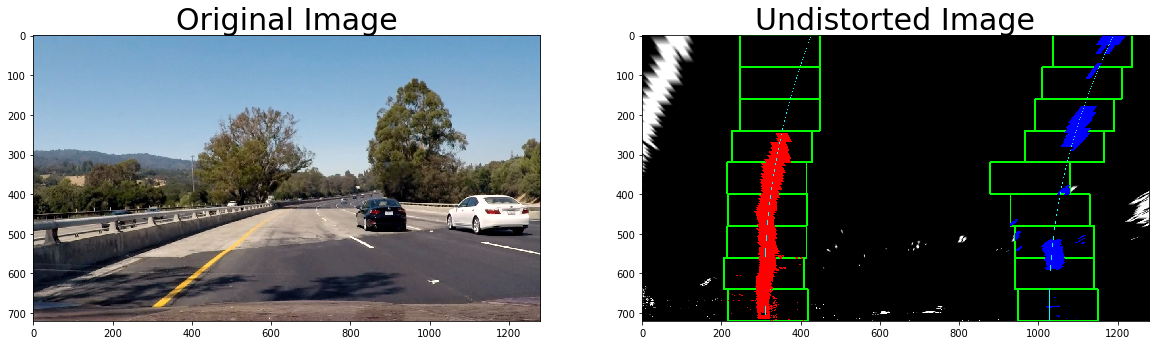

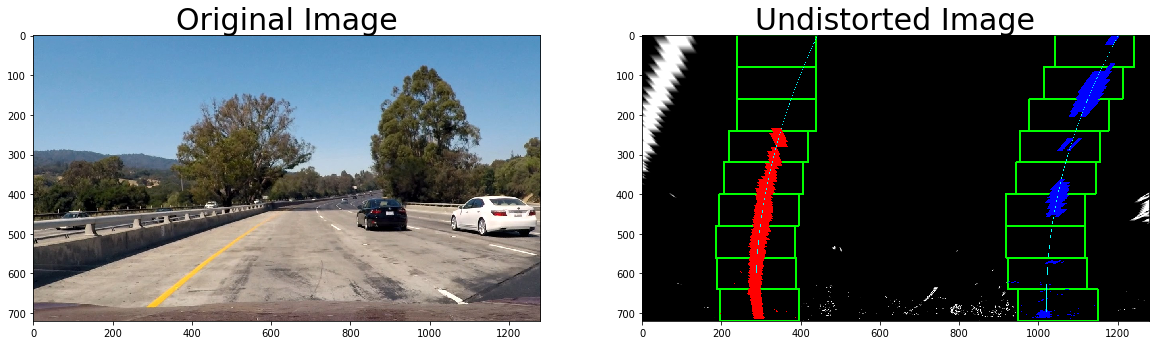

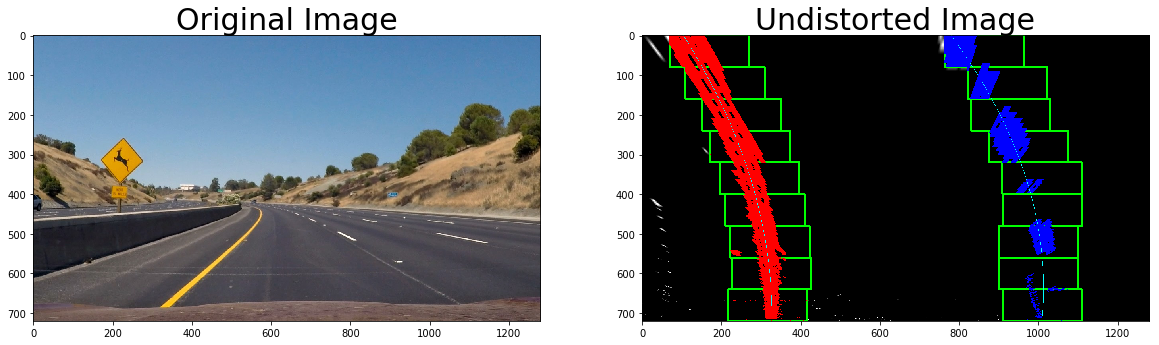

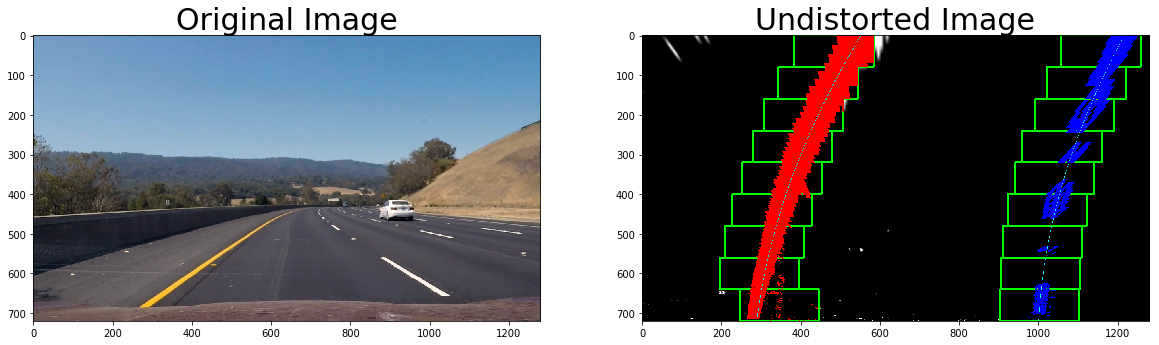

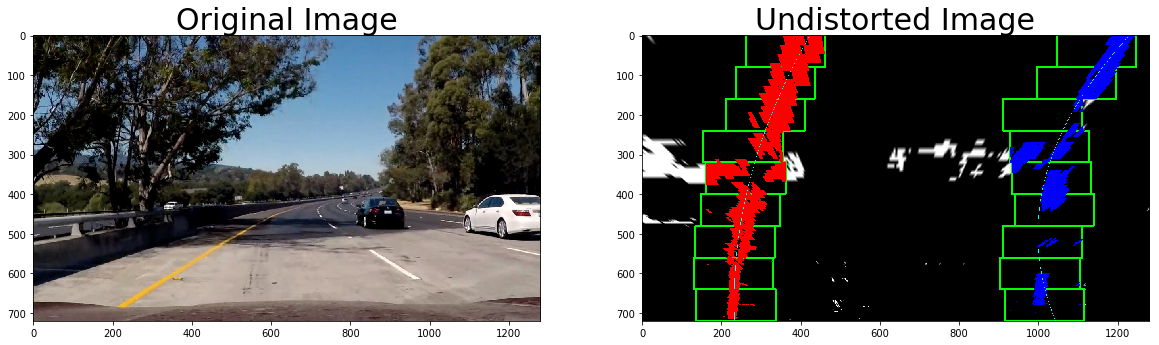

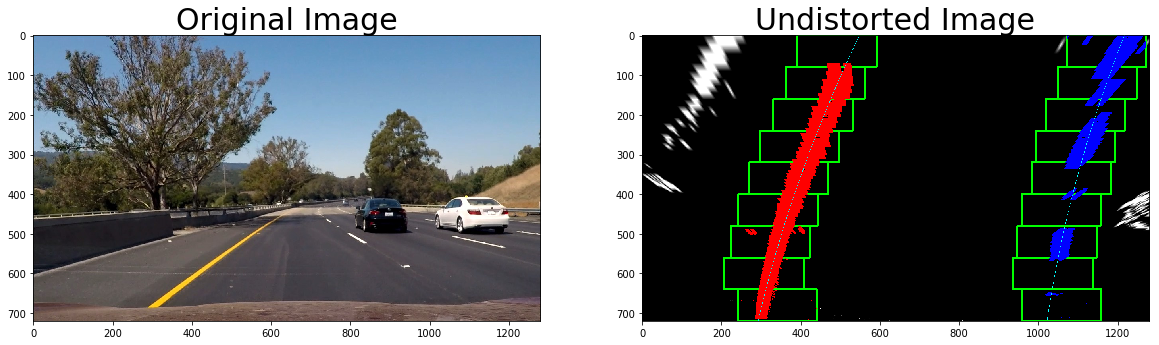

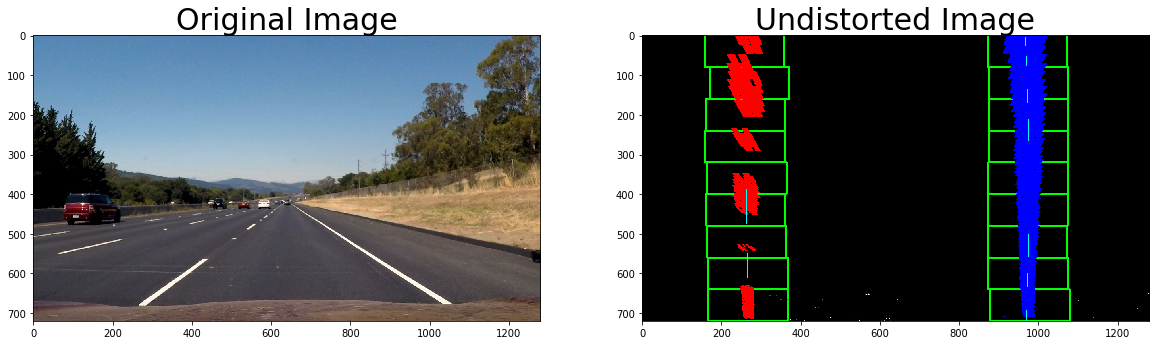

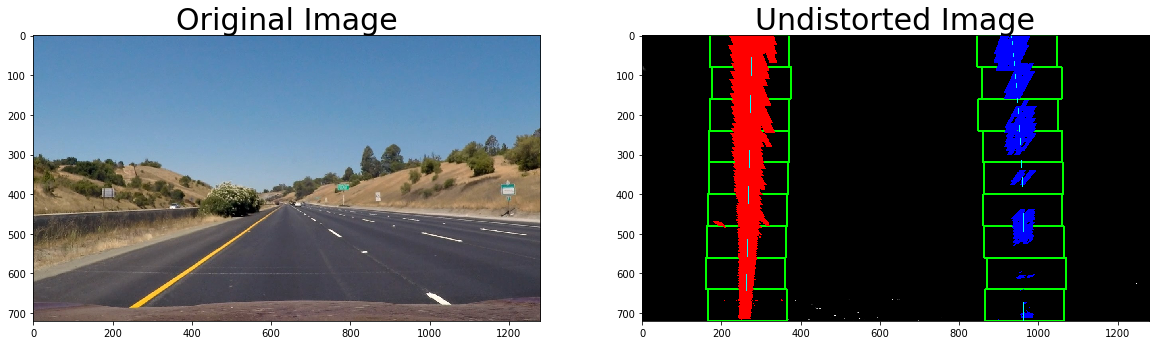

In [42]:
# testing **current** pipeline with images 

for index, fname in enumerate(images):
    img = mpimg.imread(fname)
    dst = pipeline(img, mtx, dist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst, cmap='gray')
    ax2.set_title('Undistorted Image', fontsize=30)